<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OLIST DATABASE

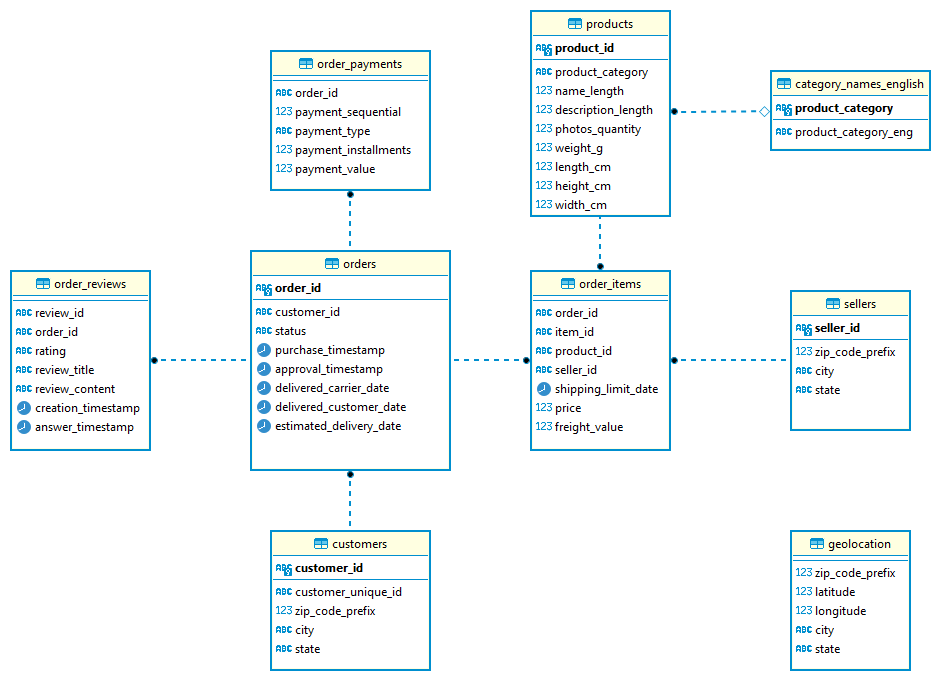

In [1]:
import pandas as pd
from sqlite3 import connect
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px

## | Requêtes SQL pour le Dashboard

* En excluant les commandes annulées, quelles sont les commandes
récentes de moins de 3 mois que les clients ont reçues avec au moins 3
jours de retard ?

* Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100
000 Real sur des commandes livrées via Olist ?

* Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
produits) ?

* Question : Quels sont les 5 codes postaux, enregistrant plus de 30
reviews, avec le pire review score moyen sur les 12 derniers mois ?

In [2]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

In [3]:
db_path = f"{folder_path}olist.db"
conn = connect(db_path)
cur = conn.cursor()

## | Les tables de la base de données olist

In [4]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print(tables)

            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


## | Récupération des données

In [5]:
def extract_transform_and_load_olist_data():

  # Extract orders
  print("Extraction des commandes ...")
  orders = pd.read_sql(
    """
    SELECT
      order_id,
      order_purchase_timestamp,
      order_approved_at,
      order_delivered_carrier_date,
      order_delivered_customer_date,
      order_estimated_delivery_date,
      strftime('%w', order_delivered_customer_date) AS delivery_day
    FROM orders o
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract order items
  print("Extraction des articles ...")
  items = pd.read_sql(
    """
    SELECT
      oi.order_id,
      COUNT(order_item_id) as nbre_items,
      SUM(price+freight_value) as total_price,
      COUNT(DISTINCT oi.product_id) AS distinct_products
    FROM order_items oi
    JOIN orders o on oi.order_id=o.order_id
    WHERE o.order_status='delivered'
    GROUP BY oi.order_id
    """,
    conn
  )

  # Extract customers
  print("Extraction des clients ...")
  customers = pd.read_sql(
    """
    SELECT
      o.order_id,
      customer_unique_id,
      customer_zip_code_prefix,
      customer_city,
      customer_state
    FROM customers c
    JOIN orders o on o.customer_id = c.customer_id
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract reviews
  print("Extraction des commentaires ...")
  reviews = pd.read_sql(
    """
    SELECT
      o.order_id,
      COUNT(r.review_id) as total_reviews,
      COALESCE(AVG(r.review_score), 0) AS mean_score_review
    FROM orders o
    LEFT JOIN order_reviews r on o.order_id=r.order_id
    WHERE o.order_status='delivered'
    GROUP BY o.order_id
    """,
    conn
  )

  # Extract payments
  print("Extraction des paiments ...")
  payments = pd.read_sql(
    """
    SELECT
      p.order_id,
      MAX(payment_installments) as payment_installments
    FROM order_pymts p
    JOIN orders o on o.order_id=p.order_id
    WHERE o.order_status='delivered'
    GROUP BY p.order_id
    """,
    conn
  )
  print("--"*20)

  # Tranform

  print("Merger des items ...")
  data = orders.merge(items, on='order_id')

  print("Merger des clients ...")
  data = data.merge(customers, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(reviews, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(payments, on='order_id')

  print("--"*20)
  print(f"Dimension du dataset: {data.shape}")

  return data

In [6]:
data = extract_transform_and_load_olist_data()

Extraction des commandes ...
Extraction des articles ...
Extraction des clients ...
Extraction des commentaires ...
Extraction des paiments ...
----------------------------------------
Merger des items ...
Merger des clients ...
Merger des paiments ...
Merger des paiments ...
----------------------------------------
Dimension du dataset: (96477, 17)


In [7]:
data.dtypes

,0
order_id,object
order_purchase_timestamp,object
order_approved_at,object
order_delivered_carrier_date,object
order_delivered_customer_date,object
order_estimated_delivery_date,object
delivery_day,object
nbre_items,int64
total_price,float64
distinct_products,int64


In [8]:
# Conversion explicite des colonnes en datetime si ce n'est pas fait correctement
date_columns = [
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_customer_date", "order_delivered_carrier_date",
    "order_estimated_delivery_date"
]

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [9]:
data.dtypes

,0
order_id,object
order_purchase_timestamp,datetime64[ns]
order_approved_at,datetime64[ns]
order_delivered_carrier_date,datetime64[ns]
order_delivered_customer_date,datetime64[ns]
order_estimated_delivery_date,datetime64[ns]
delivery_day,object
nbre_items,int64
total_price,float64
distinct_products,int64


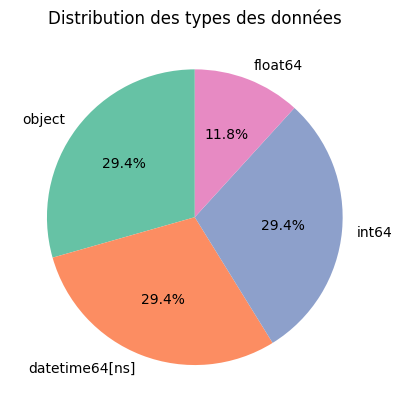

In [10]:
dtype_counts = data.dtypes.value_counts()

dtype_counts.plot.pie(autopct="%1.1f%%", labels=dtype_counts.index,startangle=90, colors=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"])
plt.title("Distribution des types des données")
plt.ylabel("")  # Remove default ylabel
plt.show()

In [11]:
data.isna().sum().sort_values(ascending=False)

,0
order_approved_at,14
order_delivered_customer_date,8
delivery_day,8
order_delivered_carrier_date,2
order_id,0
customer_zip_code_prefix,0
mean_score_review,0
total_reviews,0
customer_state,0
customer_city,0


Nous constatons la presence de valeurs manquantes dans les variables:
- **order_approved_at**
- **order_delivered_customer_date**
- **order_delivered_carrier_date**

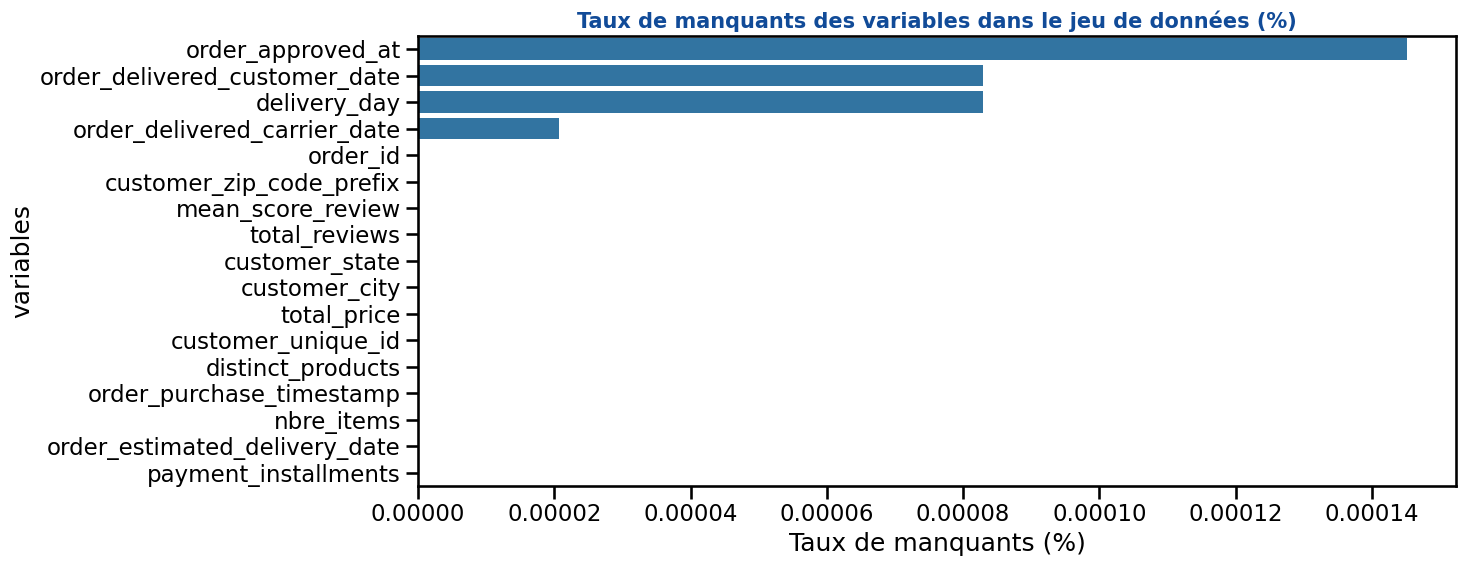

In [12]:
sns.set_context("talk")

vars = pd.DataFrame(data.isnull().mean(), columns=['Taux_de_Null']).sort_values(
    by='Taux_de_Null', ascending=False)
fig = plt.figure(figsize=(15, 6))

font_title = {'color':  '#114b98','weight': 'bold','size': 15}

sns.barplot(x=vars.Taux_de_Null, y=vars.index, data=vars)

# Seuil pour suppression des variables
# plt.axvline(x=max_threshold, linewidth=2, color = 'r')
# plt.text(max_threshold+0.1, 20, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de manquants des variables dans le jeu de données (%)",
          fontdict=font_title)
plt.xlabel("Taux de manquants (%)")
plt.ylabel("variables")

fig.tight_layout()

plt.show()

In [13]:
data.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,nbre_items,total_price,distinct_products,customer_zip_code_prefix,total_reviews,mean_score_review,payment_installments
count,96477,96463,96475,96469,96477,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000
mean,2018-01-01 23:36:35.953657344,2018-01-02 11:00:27.838653440,2018-01-05 05:08:10.179476480,2018-01-14 12:47:59.778654464,2018-01-25 17:17:01.039211264,1.142179,159.827008,1.038538,35198.398862,0.998787,4.128390,2.928024
min,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,1.000000,9.590000,1.000000,1003.000000,0.000000,0.000000,0.000000
25%,2017-09-14 09:09:57,2017-09-14 14:50:09.500000,2017-09-18 16:47:13,2017-09-25 22:18:08,2017-10-05 00:00:00,1.000000,61.850000,1.000000,11355.000000,1.000000,4.000000,1.000000
50%,2018-01-20 19:46:23,2018-01-22 13:50:04,2018-01-24 16:14:57,2018-02-02 19:36:08,2018-02-16 00:00:00,1.000000,105.280000,1.000000,24435.000000,1.000000,5.000000,2.000000
75%,2018-05-05 18:56:01,2018-05-06 11:01:45.500000,2018-05-08 14:35:00,2018-05-15 22:56:45,2018-05-28 00:00:00,1.000000,176.260000,1.000000,59056.000000,1.000000,5.000000,4.000000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,21.000000,13664.080000,8.000000,99980.000000,3.000000,5.000000,24.000000
std,NaN,NaN,NaN,NaN,NaN,0.538773,218.795346,0.227943,29839.786348,0.110728,1.323427,2.712723


In [14]:
data.describe(include='O')

,order_id,delivery_day,customer_unique_id,customer_city,customer_state
count,96477,96469,96477,96477,96477
unique,96477,7,93357,4085,27
top,e481f51cbdc54678b7cc49136f2d6af7,1,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,18892,15,15045,40500


In [15]:
data.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_day,nbre_items,total_price,distinct_products,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_reviews,mean_score_review,payment_installments
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2,1,38.71,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,4.0,1
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2,1,141.46,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,4.0,1
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,5,1,179.12,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,5.0,3
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,6,1,72.20,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,5.0,1
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,5,1,28.62,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,5.0,1


## | Gestion des Valeurs manquantes

Nous avons remarqué plus haut que les trois varibales **order_approved_at**, **order_delivered_customer_date**, **order_delivered_carrier_date** presentent des valeurs manquantes qui devront etre imputer ou supprimer avant de poursuivre l'ananlyse.

L'approche que nous allons choisir consiste:

- Pour la variable **order_approved_at**: nous allons calculer le temps moyen entre order_purchase_timestamp (le moment où l'achat a été effectué) et order_approved_at (le moment où l'achat a été validé) puis ensuite nous allons imputer les valeur manquantes en addition order_purchase_timestamp avec la moyenne trouvée.

- Pour la variable **order_delivered_customer_date**: Nous allons calculer la moyenne entre cette variable et la date estimée de la livraison (**order_estimated_delivery_date**)

- Pour la variable **order_delivered_carrier_date**, on imputera les valeurs manquantes par la moyenne entre la date de validation et la variable.

In [16]:
missing_cols = data.columns[data.isnull().any()].tolist()
print(missing_cols)

['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'delivery_day']


### | order_approved_at

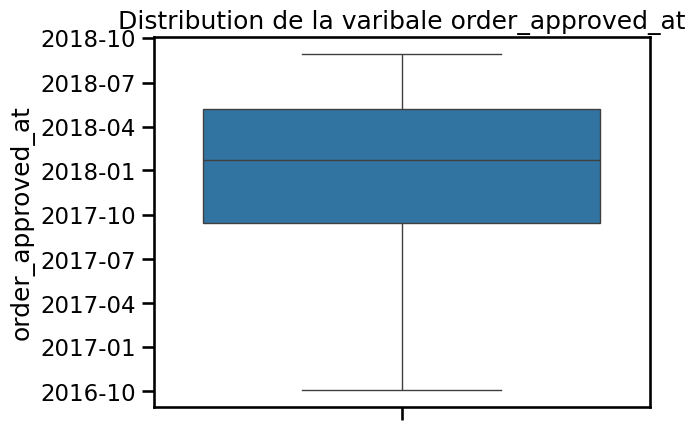

In [17]:
sns.boxplot(data.order_approved_at)
plt.title("Distribution de la varibale order_approved_at")
plt.show()

In [18]:
data["approval_delay"] = (data["order_approved_at"] - data["order_purchase_timestamp"]).dt.total_seconds() / 3600
mean_approval_delay = data["approval_delay"].mean()

In [19]:
print(f"En moyenne les commandes sont validée en {mean_approval_delay:.0f} heures")

En moyenne les commandes sont validée en 10 heures


In [20]:
# Imputation des valeurs manquantes pour order_approved_at
data.loc[data["order_approved_at"].isna(), "order_approved_at"] = data["order_purchase_timestamp"] + pd.to_timedelta(mean_approval_delay, unit="h")

In [21]:
data.order_approved_at.isna().sum()

0

### | order_delivered_customer_date

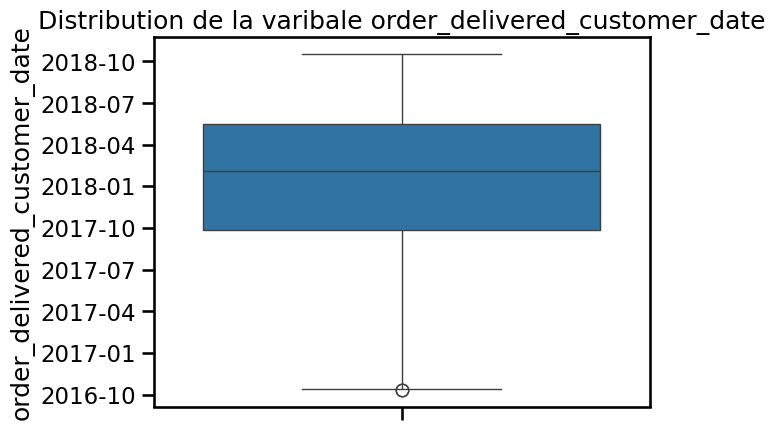

In [22]:
sns.boxplot(data.order_delivered_customer_date)
plt.title("Distribution de la varibale order_delivered_customer_date")
plt.show()

In [23]:
# Calcul du délai moyen entre order_delivered_customer_date et order_estimated_delivery_date
data["delivery_delay"] = (data["order_delivered_customer_date"] - data["order_estimated_delivery_date"]).dt.total_seconds() / (3600*24)
mean_delivery_delay = data["delivery_delay"].mean()
if mean_delivery_delay > 0:
  print(f"En moyenne les commandes sont livrée {-mean_delivery_delay:.0f} jours en retard")
else:
  print(f"En moyenne les commandes sont livrée {-mean_delivery_delay:.0f} jour en avance")

En moyenne les commandes sont livrée 11 jour en avance


In [24]:
# Imputation des valeurs manquantes pour order_delivered_customer_date
data.loc[data["order_delivered_customer_date"].isna(), "order_delivered_customer_date"] = data["order_estimated_delivery_date"] + pd.to_timedelta(mean_delivery_delay, unit="d")

In [25]:
data.order_delivered_customer_date.isna().sum()

0

### | order_delivered_carrier_date

In [26]:
# Calcul du délai moyen entre order_approved_at et order_delivered_carrier_date
data["carrier_delay"] = (data["order_delivered_carrier_date"] - data["order_approved_at"]).dt.total_seconds() / (3600*24)
mean_carrier_delay = data["carrier_delay"].mean()

print(f"En moyenne les commandes sont prises en charges par le transporteur sous {mean_carrier_delay:.0f} jours")

En moyenne les commandes sont prises en charges par le transporteur sous 3 jours


In [27]:
# Imputation des valeurs manquantes pour order_delivered_carrier_date
data.loc[data["order_delivered_carrier_date"].isna(), "order_delivered_carrier_date"] = data["order_approved_at"] + pd.to_timedelta(mean_carrier_delay, unit="d")

In [28]:
# Nettoyage : suppression des colonnes temporaires
data.drop(columns=["approval_delay", "delivery_delay", "carrier_delay"], inplace=True)

In [29]:
data.isna().sum()

,0
order_id,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,0
order_delivered_customer_date,0
order_estimated_delivery_date,0
delivery_day,8
nbre_items,0
total_price,0
distinct_products,0


## | Jour de livraison le plus fréquent de la semaine

In [30]:
# Dictionnaire pour mapper les valeurs numériques des jours aux vrais noms en français
jours_fr = {
    0: "Dimanche", 1: "Lundi", 2: "Mardi", 3: "Mercredi",
    4: "Jeudi", 5: "Vendredi", 6: "Samedi"
}
data["delivery_day"] = data["order_delivered_customer_date"].dt.dayofweek.map(jours_fr)

delivery_df = data.groupby("delivery_day")['order_id'].count().reset_index().sort_values(by="order_id")

# Constructing horizontal bar chart
fig = px.bar(delivery_df,
             x = 'delivery_day',
             y = 'order_id',
             title = '',
             labels = {'order_id': 'Count'},
             template = 'simple_white',
             height = 500,
             width = 700,
             text_auto = True)
fig.show()

## | Montant des commandes

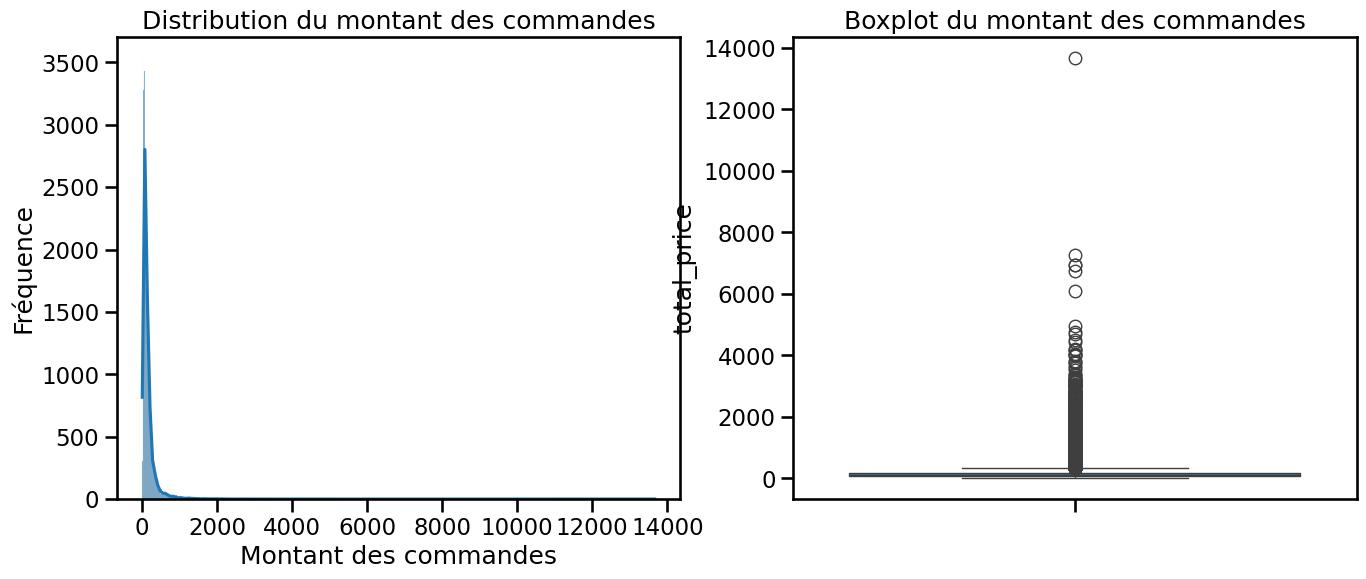

In [31]:
# Distribution du montant des commandes
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data['total_price'], kde=True, ax=ax0)
ax0.set_title('Distribution du montant des commandes')
ax0.set_xlabel('Montant des commandes')
ax0.set_ylabel('Fréquence')


sns.boxplot(data['total_price'], ax=ax1)
ax1.set_title('Boxplot du montant des commandes')

plt.show()

## | Nombre d'articles par commande

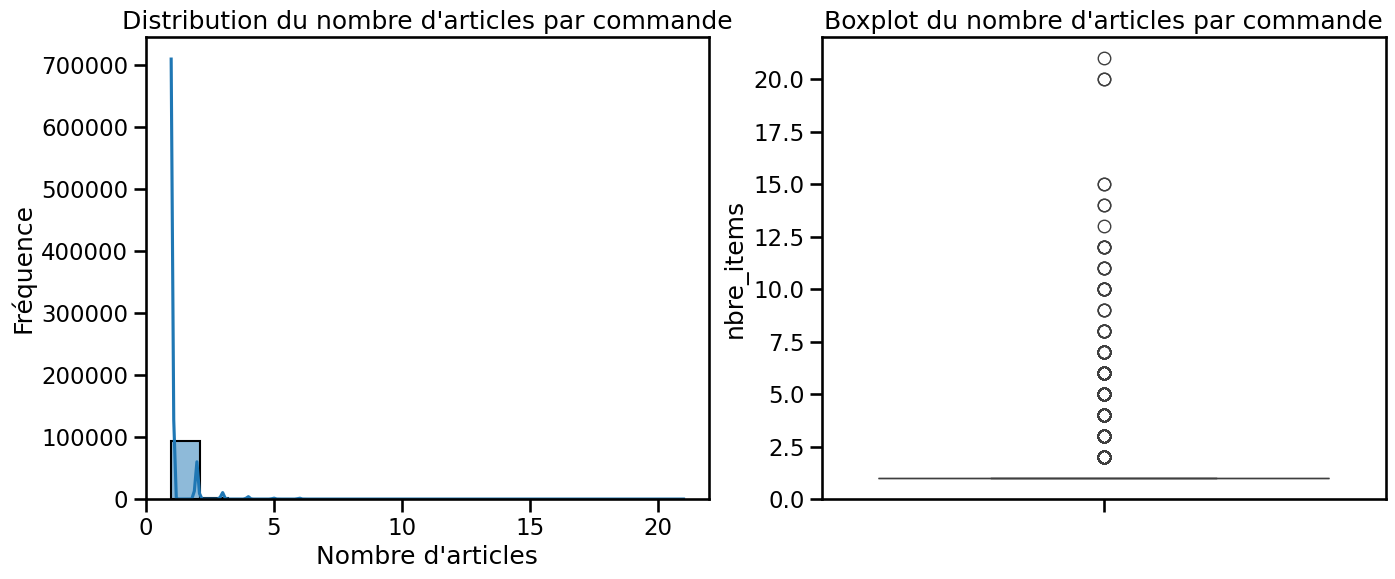

In [32]:
# Distribution du nombre d'articles par commande
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data['nbre_items'], kde=True, ax=ax0)
ax0.set_title('Distribution du nombre d\'articles par commande')
ax0.set_xlabel('Nombre d\'articles')
ax0.set_ylabel('Fréquence')

sns.boxplot(data['nbre_items'], ax=ax1)
ax1.set_title('Boxplot du nombre d\'articles par commande')

plt.show()

## | RFM Feature engineering

In [ ]:
RFMScores = data.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', days_latest),
    frequency=('order_id', 'count'),
    monetary=('payment_value', 'sum'),
    satisfaction=('review_score', 'mean'),
    nb_articles=('nb_articles', 'mean'),
    nb_diff_products=('nb_diff_products', 'mean'),
    last_purch=('order_purchase_timestamp', 'max'),
)

In [36]:
rfm_df = data.copy()

# Recency
last_date = rfm_df['order_purchase_timestamp'].max()
rfm_df['Recency'] = (last_date - rfm_df['order_purchase_timestamp']).dt.days

# Frequency
frequency = rfm_df.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency.columns = ['customer_unique_id', 'Frequency']
rfm_df = rfm_df.merge(frequency, on='customer_unique_id')


# Monetary Value
monetary_value = rfm_df.groupby('customer_unique_id')['total_price'].sum().reset_index()
monetary_value.columns = ['customer_unique_id', 'MonetaryValue']
rfm_df = rfm_df.merge(monetary_value, on='customer_unique_id')

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

quantiles = rfm_df[['Recency', 'Frequency', 'MonetaryValue']].quantile(q=[0.25, 0.5, 0.75])
rfm_df['R'] = rfm_df['Recency'].apply(rfm_score, args=('Recency', quantiles))
rfm_df['F'] = rfm_df['Frequency'].apply(rfm_score, args=('Frequency', quantiles))
rfm_df['M'] = rfm_df['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles))

rfm_df['RFM_Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df['RFM_Score'] = rfm_df[['R', 'F', 'M']].sum(axis=1)

display(rfm_df[['customer_unique_id', 'Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M', 'RFM_Score', 'RFM_Segment']].head())


,customer_unique_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment
0,7c396fd4830fd04220f754e42b4e5bff,331,2,82.82,3,4,2,9,342
1,af07308b275d755c9edb36a90c618231,35,1,141.46,1,1,3,5,113
2,3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12,1,1,3,5,113
3,7c142cf63193a1473d2e66489a9ae977,283,1,72.20,3,1,2,6,312
4,72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62,2,1,1,4,211


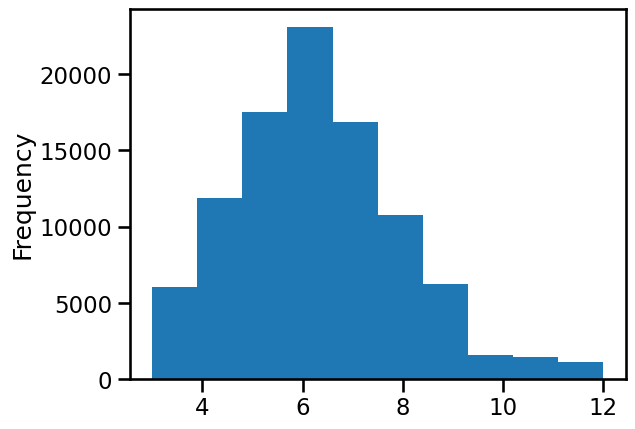

In [51]:
rfm_df.RFM_Score.plot.hist()
plt.show()

In [69]:
rfm_df['cat'] = pd.qcut(rfm_df.RFM_Score, duplicates='drop', q=4, labels=['low', 'average', 'good', 'top'])
display(rfm_df[['RFM_Score','cat']].sort_values(by='cat', ascending=False))

,RFM_Score,cat
0,9,top
46701,11,top
18485,12,top
46665,9,top
18481,8,top
...,...,...
46957,5,low
46958,5,low
46962,5,low
46967,4,low


## | Sauvegarde des données nettoyées

In [ ]:
rfm_df.to_csv(f"{folder_path}olist_customer_cleaned_data.csv", index=False)